# Factor Analysis for Dimensionality Reduction

This script performs Factor analysis (FA) for dimensionality reduction and feature selection on the regression training data set of molecular descriptors. 

Dimensionality Reduction with FA:
Uses PCA to compute eigenvalues for all components to visualize variance explained.
Outputs a scree plot showing the variance explained by each principal component.
Select number of components based on the elblow of the scree plot (e.g. 15) 

Factor Loadings and Feature Selection:
Extracts factors and sorts them by absolute values.
Dynamically selects features using a threshold based on the mean and standard deviation of absolute loadings.
Saves sorted loadings and selected features to CSV files for training model (we eventually chose reduced features from PCA in this project since it seems to select more relevant features)


Visualizes the pairs of principal components colored by Potency categories (High, Medium, Low).


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import os
import glob

from matplotlib import rcParams
# Global parameters for matplotlib
rcParams['font.family'] = 'Arial'
rcParams['axes.titlesize'] = 18  # Font size for titles
rcParams['axes.labelsize'] = 18  # Font size for axis labels
rcParams['xtick.labelsize'] = 18  # Font size for tick labels
rcParams['ytick.labelsize'] = 18  # Font size for tick labels
rcParams['legend.fontsize'] = 20  # Adjust legend font size

## Perform FA

In [2]:
# Define paths
input_dir = "../../3_train_test_split/"
output_dir = "FA_results/"
features_dir = os.path.join(output_dir, "selected_features/")
components_dir = os.path.join(output_dir, "factor_components/")
plots_dir = "plots"

problem_types = ["regression", "classification"]
seed = 42
# Create directories if they don't exist
os.makedirs(features_dir, exist_ok=True)
os.makedirs(components_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [3]:
def generate_plots(X_factors_df, y_train, X, factor_loadings, num_factors, sorted_factor_loadings, plots_dir, problem_type):
    """Generate and save plots for Factor Analysis."""
    # Clean and map y_train for classification
    if problem_type == "classification":
        y_train = y_train.str.split("\n").str[0].str.strip()  # Clean strings
        category_to_color = {
            "High Potency": 'blue',
            "Medium Potency": 'red',
            "Low Potency": 'green'
        }
        y_color = y_train.map(category_to_color)

    # Scree Plot
    pca = PCA().fit(X)
    eigenvalues = pca.explained_variance_

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', label="All Components", alpha=0.5)
    plt.plot(range(1, num_factors + 1), eigenvalues[:num_factors], marker='o', color='orange', label=f"Top {num_factors} Components")
    plt.axhline(y=1, color='red', linestyle='--', label="Eigenvalue = 1")
    plt.xlabel("Component Number")
    plt.ylabel("Eigenvalue")
    plt.title(f"Scree Plot ({problem_type.capitalize()})")
    plt.legend()
    plt.savefig(os.path.join(plots_dir, f"{problem_type}_FA_Scree_plot_highlighted.png"), format='png', dpi=300)
    plt.show()

    # Histogram of Factor Loadings
    mean_loading = sorted_factor_loadings.mean()
    std_loading = sorted_factor_loadings.std()
    threshold = mean_loading + std_loading

    plt.figure(figsize=(10, 6))
    plt.hist(sorted_factor_loadings, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(mean_loading, color='orange', linestyle='--', label='Mean')
    plt.axvline(threshold, color='red', linestyle='--', label='Mean + 1 Std')
    plt.xlabel("Factor Loadings (Absolute Sum)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Factor Loadings ({problem_type.capitalize()})")
    plt.legend()
    plt.savefig(os.path.join(plots_dir, f"{problem_type}_Factor_Loadings_Distribution.png"), dpi=300)
    plt.show()

    # Factor Scatter Plot
    plt.figure(figsize=(10, 8))
    if problem_type == "classification":
        plt.scatter(X_factors_df['Factor1'], X_factors_df['Factor2'], c=y_color, alpha=0.7)
    else:
        plt.scatter(X_factors_df['Factor1'], X_factors_df['Factor2'], c=y_train, cmap='viridis', alpha=0.7)
    plt.xlabel("Factor 1")
    plt.ylabel("Factor 2")
    plt.title(f"Factor Analysis Scatter Plot ({problem_type.capitalize()})")
    if problem_type == "classification":
        plt.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
            for label, color in category_to_color.items()
        ])
    else:
        plt.colorbar(label="Target Variable")
    plt.savefig(os.path.join(plots_dir, f"{problem_type}_FA_Factor1_Factor2_Scatter.png"), dpi=300)
    plt.show()

    # Pair Plot of Top Factors
    factor_top_components = X_factors_df.iloc[:, :num_factors].copy()
    factor_top_components['Target'] = y_train

    pair_plot = sns.pairplot(
        factor_top_components,
        hue='Target',
        palette=category_to_color if problem_type == "classification" else 'viridis',
        diag_kind='kde'
    )
    pair_plot.fig.savefig(os.path.join(plots_dir, f"{problem_type}_FA_All_Factors_PairPlot.png"), format='svg', dpi=300)
    plt.show()

    # Enhanced Factor Scatter Plot by Category
    if problem_type == "classification":
        plt.figure(figsize=(10, 8))
        for category, color in category_to_color.items():
            subset = X_factors_df[y_train == category]
            plt.scatter(
                subset['Factor1'], subset['Factor2'],
                c=color,
                label=category,
                alpha=0.7
            )
        plt.xlabel("Factor 1")
        plt.ylabel("Factor 2")
        plt.title(f"Factor Analysis Plot Colored by Category ({problem_type.capitalize()})")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, f"{problem_type}_FA_Factor1_Factor2_ByCategory.png"), dpi=300)
        plt.show()

Processing regression data...
Processed test_reg.csv data for regression: features saved to FA_results/selected_features/, components saved to FA_results/factor_components/
Processed train_reg.csv data for regression: features saved to FA_results/selected_features/, components saved to FA_results/factor_components/
Processed train_reg_5.csv data for regression: features saved to FA_results/selected_features/, components saved to FA_results/factor_components/
Processed train_reg_4.csv data for regression: features saved to FA_results/selected_features/, components saved to FA_results/factor_components/
Processed train_reg_1.csv data for regression: features saved to FA_results/selected_features/, components saved to FA_results/factor_components/
Processed train_reg_3.csv data for regression: features saved to FA_results/selected_features/, components saved to FA_results/factor_components/
Processed train_reg_2.csv data for regression: features saved to FA_results/selected_features/, com

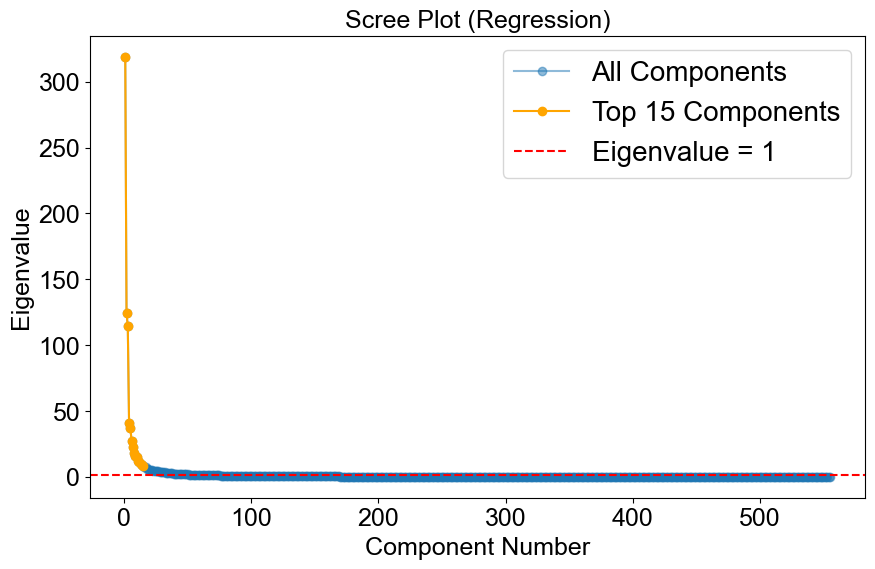

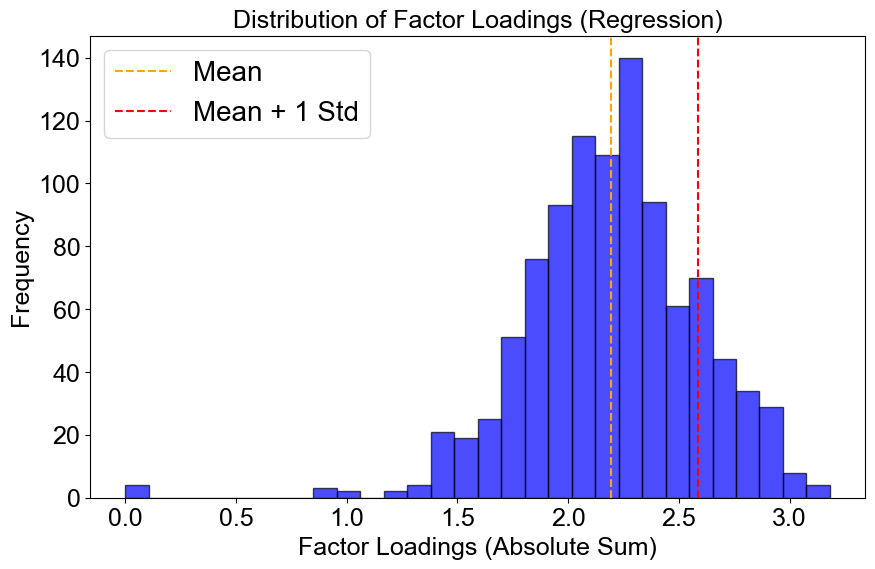

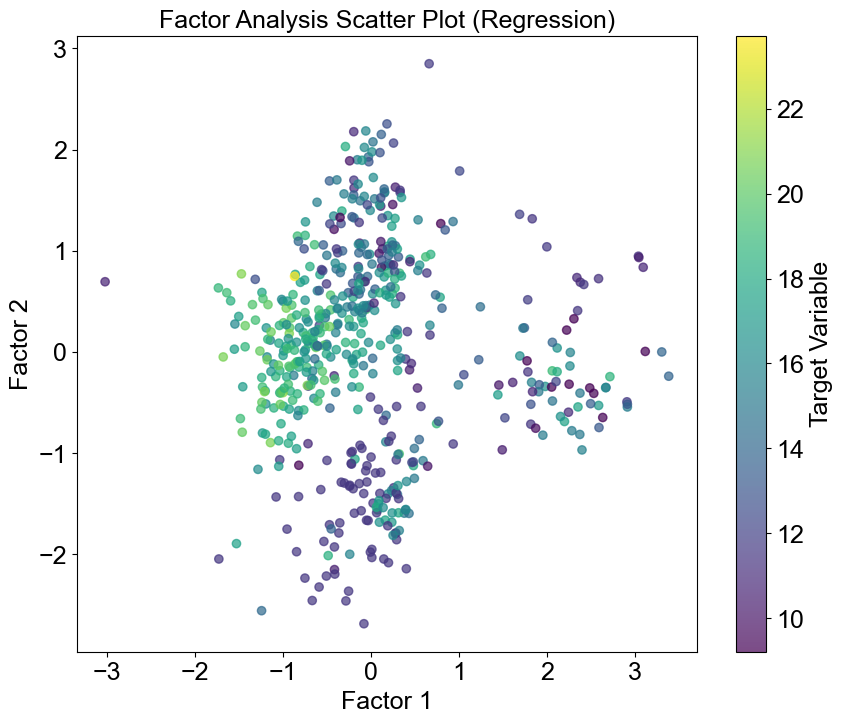

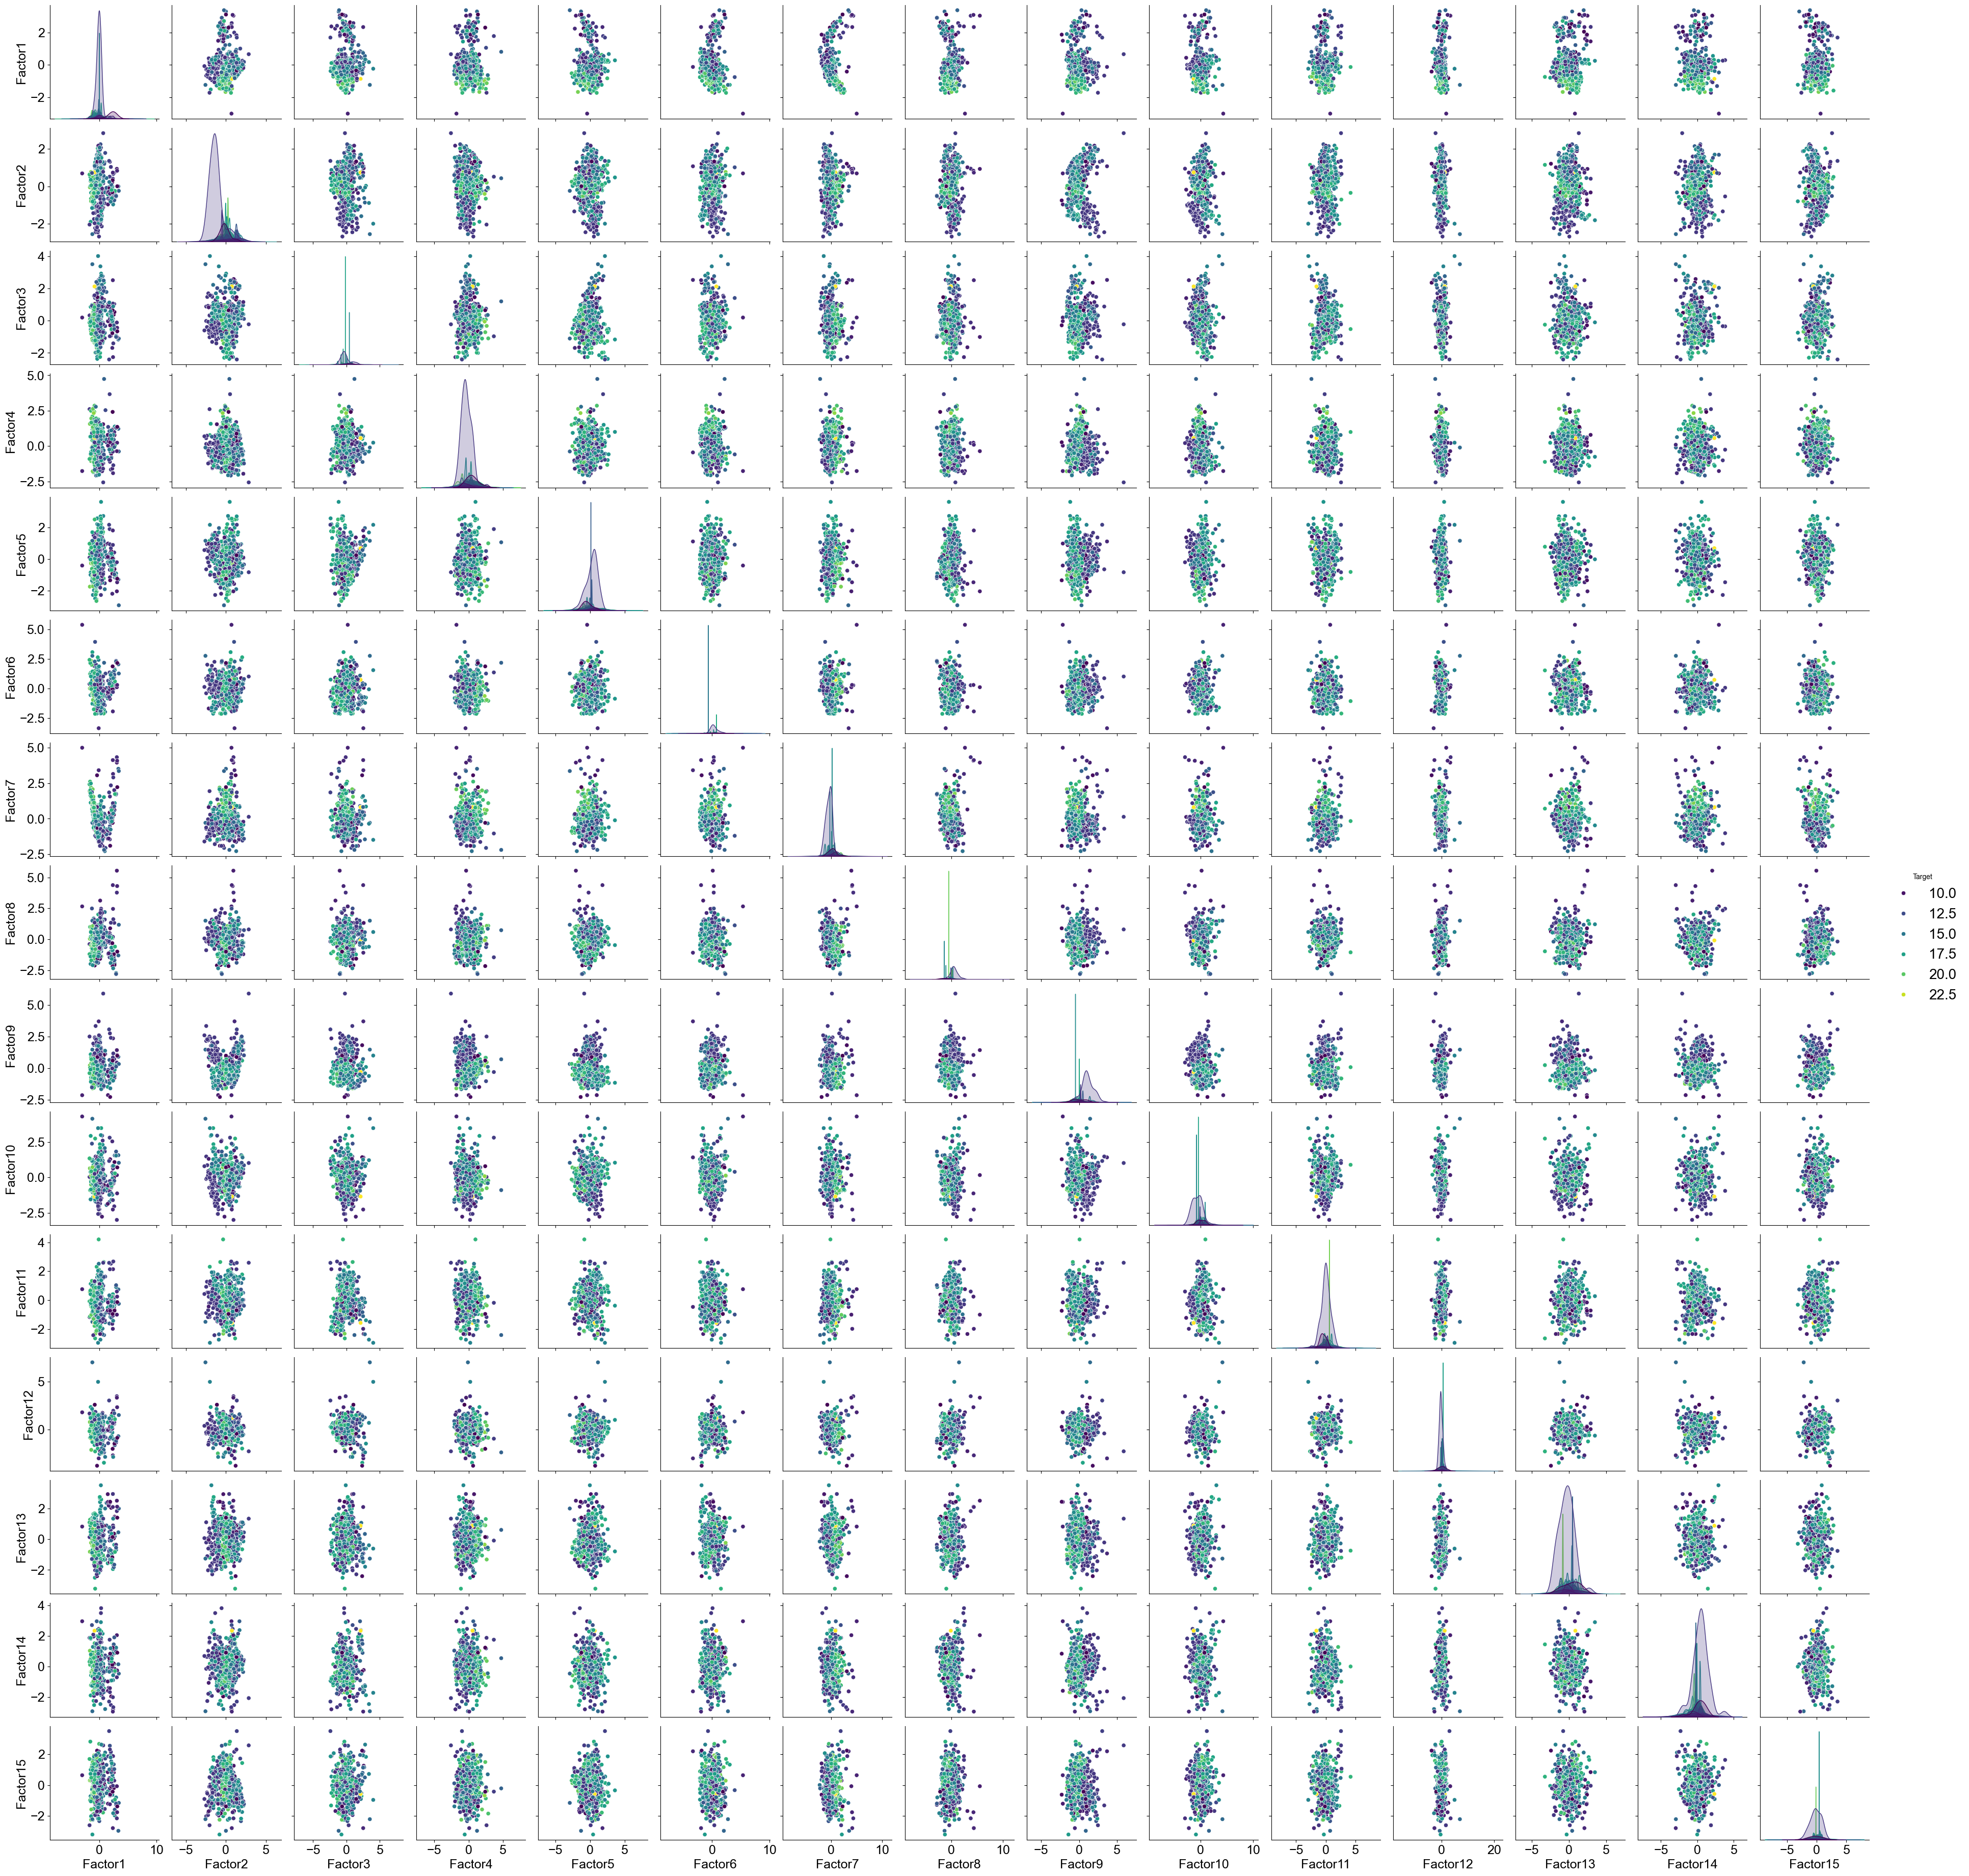

Processing classification data...


KeyError: "None of [Index(['GETAWAY_18', 'GETAWAY_19', 'GETAWAY_20', 'GETAWAY_24', 'GETAWAY_44',\n       'GETAWAY_55', 'GETAWAY_57', 'GETAWAY_58', 'GETAWAY_59', 'GETAWAY_60',\n       ...\n       'Kappa3', 'PEOE_VSA3', 'JGI1', 'JGT', 'aliphaticRings',\n       'aromaticCarbocycles', 'aromaticRings', 'HAcceptors', 'rotatableBonds',\n       'ringCount'],\n      dtype='object', length=133)] are in the [columns]"

In [4]:
for problem_type in problem_types:
    print(f"Processing {problem_type} data...")
    
    # 1. Read Data
    if problem_type == "regression":
        X = pd.read_csv(os.path.join(input_dir, "train_reg.csv")).set_index('Molecule ChEMBL ID')
        y = pd.read_csv(os.path.join(input_dir, "descriptors_all.csv")).set_index('Molecule ChEMBL ID')['-logIC50']
    elif problem_type == "classification":
        X = pd.read_csv(os.path.join(input_dir, "train_class.csv")).set_index('Molecule ChEMBL ID')
        y = pd.read_csv(os.path.join(input_dir, "descriptors_all.csv")).set_index('Molecule ChEMBL ID')['Potency']

    y_train = y.loc[X.index]

    # 2. Apply Factor Analysis and Select Features
    fa = FactorAnalysis(n_components=15, random_state=seed)
    X_factors = fa.fit_transform(X)
    factor_loadings = pd.DataFrame(fa.components_.T, index=X.columns, columns=[f'Factor{i+1}' for i in range(15)])
    selected_features = factor_loadings.abs().sum(axis=1)[
        lambda x: x > x.mean() + x.std()
    ].index.tolist()

    # Create df for FA components
    X_factors_df = pd.DataFrame(
        X_factors, 
        columns=[f'Factor{i+1}' for i in range(15)], 
        index=X.index
    )

    # 3. Compute Dummy Variable (only for regression)
    if problem_type == "regression":
        is_imputed = (np.abs(y - (-np.log(10000 * 1e-9))) < 1e-6).astype(int)

    # 4. Process and Save Data
    for file_path in glob.glob(os.path.join(input_dir, f"*_{problem_type[:3]}*")):
        # Extract the file type from the filename (e.g., "train", "test", "val")
        file_type = os.path.basename(file_path)
        
        # Read input file
        df = pd.read_csv(file_path).set_index("Molecule ChEMBL ID")

        # Process selected features
        selected_df = df[selected_features].copy()
        if problem_type == "regression":
            selected_df['is_imputed'] = is_imputed.loc[selected_df.index]
        selected_df.to_csv(os.path.join(features_dir, file_type))

        # Process factor components
        factors_df = pd.DataFrame(X_factors, index=X.index, columns=[f'Factor{i+1}' for i in range(15)])
        if problem_type == "regression":
            factors_df['is_imputed'] = is_imputed.loc[factors_df.index]
        factors_df.to_csv(os.path.join(components_dir, file_type))

        print(f"Processed {file_type} data for {problem_type}: features saved to {features_dir}, components saved to {components_dir}")
    
    # Generate Plots
    generate_plots(
        X_factors_df=X_factors_df,
        y_train=y_train,
        X=X,
        factor_loadings=factor_loadings,
        num_factors=15,
        sorted_factor_loadings=factor_loadings.abs().sum(axis=1).sort_values(ascending=False),
        plots_dir=plots_dir,
        problem_type=problem_type
    )